In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from uNet import unet_weight
n_base = 8
batch_normalization = True
dropout = True
epochs = 150
batch_size = 8
weight_strength = 1
augmentation = False


img_w, img_h = 240, 240
img_ch = 1

lr = 1e-4



In [3]:
model = unet_weight(img_w, img_h, img_ch, n_base, lr, batch_normalization, dropout, weight_strength)

Instructions for updating:
Colocations handled automatically by placer.
Model: "U-Net_wp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 8)  80          ['inputs[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                   

In [4]:
# Load pretrained model with MRI data 
model.load_weights('/home/k8s-group5/models/Unet_wmap_no_aug_e100_w_11117-1457_pretrain/variables/variables')

In [5]:
# Get MRI data
from load_data import load_data_MRI
images_path = '/DL_course_data/Lab3/MRI/Image'
masks_path = '/DL_course_data/Lab3/MRI/Mask'

In [7]:
from numpy import uint8
from scipy.ndimage import binary_dilation, binary_erosion

images, masks = load_data_MRI(images_path,masks_path)
masks = masks.astype(uint8)

weight_boundary = np.zeros(masks.shape).astype(uint8)
for i in range(len(masks)):
    weight_boundary[i,:,:,0] = binary_dilation(masks[i,:,:,0], np.ones((3,3))).astype(int) - binary_erosion(masks[i,:,:,0],np.ones((3,3))).astype(int)

Reading: 10/100  of train images
Reading: 20/100  of train images
Reading: 30/100  of train images
Reading: 40/100  of train images
Reading: 50/100  of train images
Reading: 60/100  of train images
Reading: 70/100  of train images
Reading: 80/100  of train images
Reading: 90/100  of train images
Reading: 100/100  of train images
Reading: 10/100  of train masks
Reading: 20/100  of train masks
Reading: 30/100  of train masks
Reading: 40/100  of train masks
Reading: 50/100  of train masks
Reading: 60/100  of train masks
Reading: 70/100  of train masks
Reading: 80/100  of train masks
Reading: 90/100  of train masks
Reading: 100/100  of train masks


In [8]:
from sklearn.model_selection import ShuffleSplit 
from data_generator import generator_with_weightmap


ShuffleSplit(n_splits=1, test_size=0.2).get_n_splits(images, masks)
train, val = next(ShuffleSplit(n_splits=1, test_size=0.2).split(images, masks)) 

# ----------------------------------------------------------------------------
# Initialize generators
train_gen = generator_with_weightmap(images[train], masks[train], weight_boundary[train], batch_size, augmentation)
val_gen = generator_with_weightmap(images[val], masks[val], np.zeros(weight_boundary[val].shape), batch_size, augmentation)

In [199]:
a = next(train_gen)

In [200]:
av = model.predict(a[0])

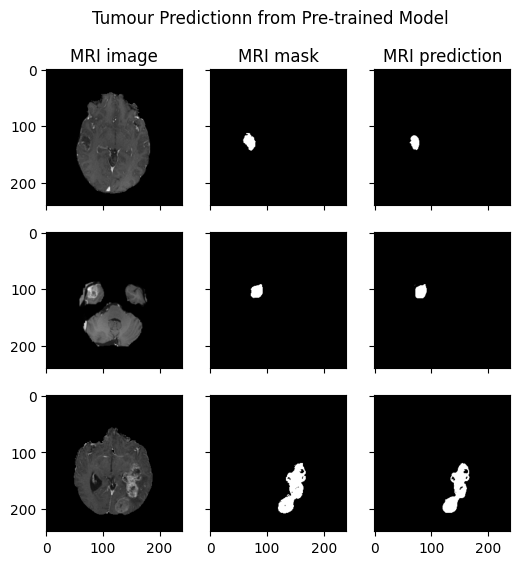

In [201]:
import matplotlib.pyplot as plt
def plot(idx, img):
    plt.imshow(img[idx], cmap='gray')
    plt.show()

idx= [3, 4, 5]
# plot(i,a[0][0])
# plot(i,a[1])
# plot(i, av)

l = [a[0][0][i], a[1][i], av[i]]
fig0, ax0 = plt.subplots(nrows=3, ncols=3, figsize=(6,6),sharex=True, sharey=True)
fig0.suptitle('Tumour Predictionn from Pre-trained Model')
ax0[0,0].set_title('MRI image')
ax0[0,1].set_title('MRI mask')
ax0[0,2].set_title('MRI prediction')



for i in range(3):
    ax0[i][0].imshow(a[0][0][idx[i]], cmap='gray')
    # ax0[i][0].set_title('MRI image')
    ax0[i][1].imshow(a[1][idx[i]], cmap='gray')
    # ax0[i][1].set_title('MRI mask')
    ax0[i][2].imshow(av[idx[i]], cmap='gray')
    # ax0[i][2].set_title('MRI prediction')
plt.show()

In [55]:
## Load trained model for lesion
model_l = unet_weight(img_w, img_h, img_ch, n_base, lr, batch_normalization, dropout, weight_strength)

Model: "U-Net_wp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 240, 240, 8)  80          ['inputs[0][0]']                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 240, 240, 8)  32         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                           

In [57]:
## Load the best model from lesion training
model_l.load_weights('/home/k8s-group5/Model_checkpoints/cv_Unet_wmap_no_aug_e150_w_1_1122-1748_best_model.tf')

In [59]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import random
import cv2 as cv

def load_data(img_w, img_h, image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    s = list(zip(image_list,mask_list))
    random.shuffle(s)
    image_list, mask_list = zip(*s)
    
    images = []
    masks = []
    idx_i = 0 
    idx_m = 0
    w, h = 233, 233

    ## Read images
    for image in image_list[0:300]:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img_data = np.zeros((w, h))
        img_data[18:215,:] = img
        # img = img[43:293,103:353]
        img = resize(img_data, (img_w, img_h), anti_aliasing=True).astype('float32')
        images.append(img)
        idx_i += 1
        if idx_i % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(idx_i, len(image_list)))

    ## Read masks
    for image in image_list[0:300]:
        m_path = os.path.join(mask_path, str.replace(image,'img','mask'))
        mask_img = np.array(cv.imread(m_path, 0), dtype=np.uint8)
        mask_img = np.divide(mask_img, 255)

        mask_data = np.zeros((w, h))
        mask_data[18:215,:] = mask_img

        # mask_img = imread(os.path.join(mask_path, str.replace(image,'img','mask')), as_gray=True)
        # mask_data = np.zeros((w, h))
        # mask_data[34:403,:] = mask_img
        # mask_img = mask_img[43:293,103:353]
        mask_img = resize(mask_data, (img_w, img_h), anti_aliasing=True).astype('float32')
        # mask_img[np.where(mask_img != 0)] = 1
        masks.append(mask_img)
        idx_m += 1
        if idx_m % 100 == 0:
             print('Reading: {0}/{1}  of train masks'.format(idx_m, len(image_list)))


    images = np.expand_dims(images, axis = -1)
    masks = np.expand_dims(masks, axis = -1)
    
    return np.array(images), np.array(masks)

In [60]:
# Load lesion data
images_path = '/home/k8s-group5/Images_cv'
masks_path = '/home/k8s-group5/Masks_cv'

images, masks = load_data(img_w, img_h, images_path,masks_path)
# masks = masks.astype(uint8)

weight_boundary = np.zeros(masks.shape).astype(uint8)
for i in range(len(masks)):
    weight_boundary[i,:,:,0] = binary_dilation(masks[i,:,:,0], np.ones((3,3))).astype(uint8) - binary_erosion(masks[i,:,:,0],np.ones((3,3))).astype(uint8)

# ShuffleSplit(n_splits=1, test_size=0.2).get_n_splits(images, masks)
# train, val = next(ShuffleSplit(n_splits=1, test_size=0.2).split(images, masks)) 
# Split data into 2 categroies.                                                                     
images_train, images_val = np.split(images,[int(0.8 * len(images))])
masks_train, masks_val = np.split(masks,[int(0.8 * len(masks))])
weight_train, weight_val = np.split(weight_boundary,[int(0.8 * len(weight_boundary))])


# ----------------------------------------------------------------------------
# Initialize generators
train_gen_l = generator_with_weightmap(images_train, masks_train, weight_train, batch_size, augmentation)
val_gen_l = generator_with_weightmap(images_val, masks_val, np.zeros(weight_val.shape), batch_size, augmentation)


Reading: 100/28339  of train images
Reading: 200/28339  of train images
Reading: 300/28339  of train images
Reading: 100/28339  of train masks
Reading: 200/28339  of train masks
Reading: 300/28339  of train masks


In [181]:
l = next(train_gen_l)

In [182]:
pl = model_l.predict(l[0])

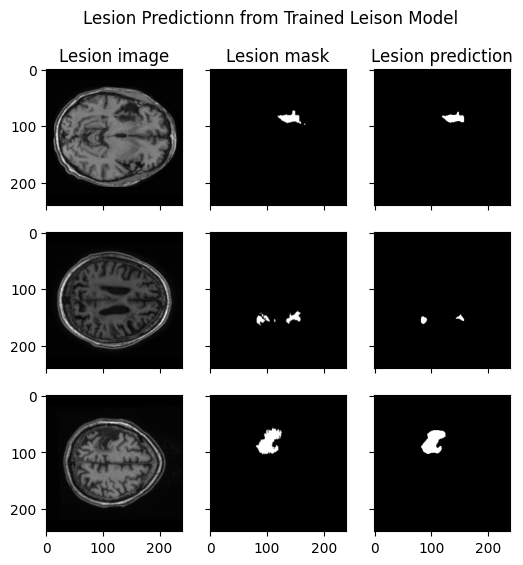

In [185]:
# idx = [0, 1 ,2]
idx = [3, 4 ,5]
# idx = [5, 6 ,7]
fig0, ax0 = plt.subplots(nrows=3, ncols=3, figsize=(6,6),sharex=True, sharey=True)
fig0.suptitle('Lesion Predictionn from Trained Leison Model')
ax0[0,0].set_title('Lesion image')
ax0[0,1].set_title('Lesion mask')
ax0[0,2].set_title('Lesion prediction')


for i in range(3):
    ax0[i][0].imshow(l[0][0][idx[i]], cmap='gray')
    ax0[i][1].imshow(l[1][idx[i]], cmap='gray')
    ax0[i][2].imshow(pl[idx[i]], cmap='gray')
plt.show()